In [3]:
from okx.api import Account
from okx.api import Trade
from okx_api import Market as Market_api
import os
import time
import math
from dotenv import load_dotenv
from okx.app import OkxSPOT
load_dotenv()
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [4]:
market = Market_api(key = '', secret = '', passphrase = '', flag = '0')
okxSPOT = OkxSPOT(
    key = "",
    secret = "",
    passphrase = "",
)

In [5]:
full_data = pd.DataFrame(columns = ['open', 'high', 'low', 'close'])

def History_finder(y, m, full_data):
    
    month = f"{y}-{m}-1"
    time_before = datetime.strptime(month, "%Y-%m-%d").timestamp()
    
    if y == 2023:
        
        time_after = datetime.strptime(date_string_after[m - 1], "%Y-%m-%d").timestamp()
        
    else:
        
        time_after = datetime.strptime('2024-1-31', "%Y-%m-%d").timestamp()
        
    result = market.get_history_candles(
        instId =  'BTC-USDT',
        before = str(round(time_before * 1000)), 
        after = str(round(time_after * 1000)), 
        bar = '1D'
    )
    
    data = pd.DataFrame(result['data'], columns = columns)
    data['date'] = pd.to_datetime(data['timestamp'], unit = 'ms')
    data.sort_values(by = 'date', inplace = True)
    data.set_index('date', inplace = True)
    data[['open', 'high', 'low', 'close']] = data[['open', 'high', 'low', 'close']].apply(pd.to_numeric)
    data.drop(['volume', 'timestamp', 'confirm', 'volCcyQuote', 'volCcy'], axis = 1, inplace = True)
    full_data = pd.concat([full_data, data])
    
    return full_data

In [21]:
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'volCcy', 'volCcyQuote', 'confirm']
date_string_after = ['2023-1-31','2023-2-28','2023-3-31','2023-4-30','2023-5-31','2023-6-30',
                     '2023-7-31','2023-8-31','2023-9-30','2023-10-31','2023-11-30','2023-12-31']
   
for m in range(8, 13):

    full_data = History_finder(2023, m, full_data)

full_data = History_finder(2024, 1, full_data)

print(full_data)

                            open     high      low    close
2023-08-01 16:00:08.192  28951.7  30039.6  28862.1  29324.0
2023-08-02 15:59:44.640  29324.0  29430.4  28923.8  29258.6
2023-08-03 15:59:21.088  29258.6  29371.3  29100.0  29272.1
2023-08-04 15:58:57.536  29272.0  29285.3  28802.2  29039.9
2023-08-05 16:00:45.056  29040.0  29137.3  28989.6  29009.0
...                          ...      ...      ...      ...
2024-01-25 16:00:33.792  39801.1  41588.8  39538.9  41418.1
2024-01-26 16:00:10.240  41418.1  42249.9  41380.4  41820.5
2024-01-27 15:59:46.688  41822.0  42838.2  41741.9  42260.2
2024-01-28 15:59:23.136  42260.3  42648.6  41617.2  42641.6
2024-01-29 15:58:59.584  42641.5  43884.4  42520.0  43377.1

[344 rows x 4 columns]


In [29]:
df = pd.DataFrame(full_data['open'])
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'ds', 'open': 'y'})
df
model = Prophet()
model.fit(df)

14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
future = model.make_future_dataframe(periods=10)
future.tail()

,ds
177,2024-02-04 15:58:59.584
178,2024-02-05 15:58:59.584
179,2024-02-06 15:58:59.584
180,2024-02-07 15:58:59.584
181,2024-02-08 15:58:59.584


In [31]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
177,2024-02-04 15:58:59.584,41615.844480,40070.918664,43175.126051
178,2024-02-05 15:58:59.584,41450.596526,40076.008855,43031.180134
179,2024-02-06 15:58:59.584,41633.481514,40158.475305,43119.341988
180,2024-02-07 15:58:59.584,41665.023271,40145.954015,43227.746088
181,2024-02-08 15:58:59.584,41679.810884,40152.195052,43232.841918


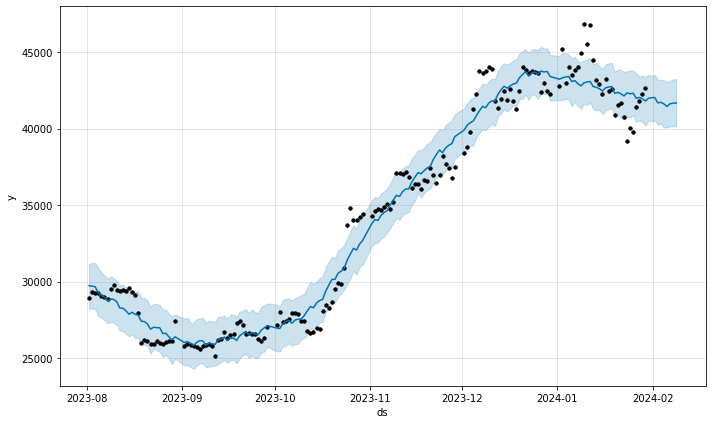

In [32]:
fig1 = model.plot(forecast)